In [1]:
import numpy as np
import keras
from keras import layers
from scipy.io import mmread
import tensorflow as tf
import pandas as pd
import time
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

import pickle
from datetime import datetime
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt 

pgf = False
if (pgf):
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })

2025-07-30 14:22:12.150249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753878132.162374  890862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753878132.166105  890862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-30 14:22:12.178486: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Fix random
seed = 42
reproductibility_mode = True

np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)

if(reproductibility_mode):
    tf.config.experimental.enable_op_determinism()

In [3]:
#log folder
log_dir = "logs/fetal_health/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


os.makedirs(log_dir, exist_ok=True)
os.makedirs("figures", exist_ok=True)

print("Logs save in :", log_dir)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Logs save in : logs/fetal_health/2025-07-30_14-22-14


In [ ]:
NUM_CLASSES = 3
CLASS_COL = "fetal_health"
dataset_path = "../../data/fetal_health.csv"

ds_import = pd.read_csv(dataset_path, sep=",", header=0, index_col=False)

In [5]:
total_column_count = len(ds_import.columns)
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_y_train = ds_import[CLASS_COL]
df_x_train = ds_import.drop([CLASS_COL], axis=1)
y = keras.utils.to_categorical(np.asarray(df_y_train.factorize()[0]))

In [6]:
#SPLIT DATASET

x_train, x_test, y_train, y_test = train_test_split(df_x_train, y, test_size=0.2, random_state=seed)
scaler = StandardScaler()
scaler.fit(x_train)
scaler.mean_
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
scaled_data_df = pd.DataFrame(x_train, columns=df_x_train.columns)

In [7]:
#HYPERPARAMETERS

hidden_units = [512, 512, 512, 512, 256]
hidden_units_med = [256, 256, 256, 256, 128]
hidden_units_low = [64, 64, 64, 64, 32]

hidden_units_verylow = [32, 32, 32, 32, 16]
dropout = [0.25, 0.25, 0.25, 0, 0]
CLASSIFIER_ACTIVATION = 'softmax'
epoch = 50
batch_size=128

In [8]:
base_time_train = []

#Standard model
model = keras.Sequential([
        keras.layers.Dense(hidden_units[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))

start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_large.keras"))
model_large_acc = acc[1]

/home/qpetit/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753878134.527828  890862 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4062 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 931,331 (3.55 MB)

 Trainable params: 931,331 (3.55 MB)

 Non-trainable params: 0 (0.00 B)

2025-07-30 14:22:15.188494: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
I0000 00:00:1753878136.310320  890907 service.cc:148] XLA service 0x7038ac00e340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753878136.310339  890907 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capabilit

---- 6.096462249755859 seconds ----


2025-07-30 14:22:21.275505: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6082696914672852 seconds ----
Test loss: 0.3479512929916382
Test accuracy: 0.9131455421447754


In [9]:
#Standard model
model = keras.Sequential([
        keras.layers.Dense(hidden_units_med[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_med[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_med[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_med[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_med[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))

start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_med.keras"))
model_med_acc = acc[1]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,291 (923.01 KB)

 Trainable params: 236,291 (923.01 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.8074281215667725 seconds ----


2025-07-30 14:22:27.817966: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6216421127319336 seconds ----
Test loss: 0.29413431882858276
Test accuracy: 0.922535240650177


In [10]:
#Standard model
model = keras.Sequential([
        keras.layers.Dense(hidden_units_low[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_low[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_low[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_low[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_low[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))

start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_low.keras"))
model_low_acc = acc[1]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,067 (62.76 KB)

 Trainable params: 16,067 (62.76 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.703454494476318 seconds ----


2025-07-30 14:22:34.257463: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6289153099060059 seconds ----
Test loss: 0.24676929414272308
Test accuracy: 0.8896713852882385


In [11]:
#Standard model
model = keras.Sequential([
        keras.layers.Dense(hidden_units_verylow[0], input_shape=(df_x_train.shape[1],), activation='relu'),
        keras.layers.Dropout(dropout[0]),
        keras.layers.Dense(hidden_units_verylow[1], activation='relu'),
        keras.layers.Dropout(dropout[1]),
        keras.layers.Dense(hidden_units_verylow[2], activation='relu'),
        keras.layers.Dropout(dropout[2]),
        keras.layers.Dense(hidden_units_verylow[3], activation='relu'),
        keras.layers.Dropout(dropout[3]),
        keras.layers.Dense(hidden_units_verylow[4], activation='relu'),
        keras.layers.Dropout(dropout[4]),
        keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
    ])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
start_time = time.time()
history = model.fit(x_train, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
base_time_train.append(time.time() - start_time)
print("---- %s seconds ----" % (time.time() - start_time))

start_time = time.time()
acc = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
print("---- %s seconds ----" % (time.time() - start_time))

print("Test loss:", acc[0])
print("Test accuracy:", acc[1])

model.save(os.path.join(log_dir, "model_verylow.keras"))
model_verylow_acc = acc[1]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 32)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,451 (17.39 KB)

 Trainable params: 4,451 (17.39 KB)

 Non-trainable params: 0 (0.00 B)

---- 5.670785427093506 seconds ----


2025-07-30 14:22:40.664123: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- 0.6288285255432129 seconds ----
Test loss: 0.2529251277446747
Test accuracy: 0.8943662047386169


In [12]:
MAX_EV_EXPLORE = 10

In [13]:
def readMTX(input_path):
    is_init = False
    count = 0
    expected = 0
    with open(input_path, "r") as file:
        lines = file.readlines()
        for line in lines:
            list_line = line.split()
            if list_line[0].isdigit():
                if(not is_init):
                    is_init = True
                    ev = np.zeros((int(list_line[0]), int(list_line[1])))
                    expected = int(list_line[2])
                else:
                    ev[int(list_line[0]) - 1][int(list_line[1]) - 1] = float(list_line[2])
                    count = count + 1
                
    if(expected != count):
        print("Err: Not the same nnz between expected and find ", str(count), "/", str(expected))
    return ev

In [ ]:
acc_test_large = []
acc_test_med = []
acc_test_low = []
acc_test_verylow = []
emb_time_train = []


for i in range(MAX_EV_EXPLORE):
    path_ev = "../../data/output/fetal_health/eigen_" + str(i + 1) + ".mtx"
    ev = readMTX(path_ev)
    print(ev.shape)
    x_train_emb = np.matmul(x_train,ev)
    x_test_emb = np.matmul(x_test,ev)
    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train large : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate large : %s seconds ----" % (time.time() - start_time))
    acc_test_large.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_large.keras"))

    #REDUCED SIZE
    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_med[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_med[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_med[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_med[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_med[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train med : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate med : %s seconds ----" % (time.time() - start_time))
        
    acc_test_med.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_med.keras"))


    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_low[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_low[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_low[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_low[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_low[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train low : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate low : %s seconds ----" % (time.time() - start_time))
        
    acc_test_low.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_low.keras"))


    model_emb = keras.Sequential([
            keras.layers.Dense(hidden_units_verylow[0], input_shape=(x_train_emb.shape[1],), activation='relu'),
            keras.layers.Dropout(dropout[0]),
            keras.layers.Dense(hidden_units_verylow[1], activation='relu'),
            keras.layers.Dropout(dropout[1]),
            keras.layers.Dense(hidden_units_verylow[2], activation='relu'),
            keras.layers.Dropout(dropout[2]),
            keras.layers.Dense(hidden_units_verylow[3], activation='relu'),
            keras.layers.Dropout(dropout[3]),
            keras.layers.Dense(hidden_units_verylow[4], activation='relu'),
            keras.layers.Dropout(dropout[4]),
            keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER_ACTIVATION)
        ])
    model_emb.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    start_time = time.time()
    history = model_emb.fit(x_train_emb, y_train,epochs=epoch, batch_size=batch_size, verbose=0)
    emb_time_train.append(time.time() - start_time)
    print("---- Train very low : %s seconds ----" % (time.time() - start_time))
    start_time = time.time()
    acc_emb = model_emb.evaluate(x_test_emb, y_test, batch_size=batch_size, verbose=0)
    print("---- Evaluate very low : %s seconds ----" % (time.time() - start_time))
        
    acc_test_verylow.append(acc_emb[1])
    model_emb.save(os.path.join(log_dir, "emb_" + str(i) + "_model_verylow.keras"))
    

(21, 1)
---- Train large : 5.499786138534546 seconds ----


2025-07-30 14:22:47.095946: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.5162606239318848 seconds ----
---- Train med : 5.323844909667969 seconds ----


2025-07-30 14:22:53.027744: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.5051429271697998 seconds ----
---- Train low : 5.154993057250977 seconds ----


2025-07-30 14:22:58.763806: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.5098867416381836 seconds ----
---- Train very low : 5.212470531463623 seconds ----


2025-07-30 14:23:04.555949: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.5105197429656982 seconds ----
(21, 2)
---- Train large : 5.447378396987915 seconds ----


2025-07-30 14:23:10.616191: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.6403870582580566 seconds ----
---- Train med : 5.4302756786346436 seconds ----


2025-07-30 14:23:16.773456: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.45064520835876465 seconds ----
---- Train low : 5.2318620681762695 seconds ----


2025-07-30 14:23:22.521600: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4489779472351074 seconds ----
---- Train very low : 5.234225749969482 seconds ----


2025-07-30 14:23:28.272493: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4430828094482422 seconds ----
(21, 3)
---- Train large : 5.424081325531006 seconds ----


2025-07-30 14:23:34.216442: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4489467144012451 seconds ----
---- Train med : 5.343458652496338 seconds ----


2025-07-30 14:23:40.096397: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4386940002441406 seconds ----
---- Train low : 5.600783586502075 seconds ----


2025-07-30 14:23:46.209353: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4451255798339844 seconds ----
---- Train very low : 5.2653608322143555 seconds ----


2025-07-30 14:23:51.989250: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4441356658935547 seconds ----
(21, 4)
---- Train large : 5.429760694503784 seconds ----


2025-07-30 14:23:57.933367: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4477651119232178 seconds ----
---- Train med : 5.378349542617798 seconds ----


2025-07-30 14:24:03.844974: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.44657278060913086 seconds ----
---- Train low : 5.268191814422607 seconds ----


2025-07-30 14:24:09.631440: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.442826509475708 seconds ----
---- Train very low : 5.345019102096558 seconds ----


2025-07-30 14:24:15.488843: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4442002773284912 seconds ----
(21, 5)
---- Train large : 5.508913040161133 seconds ----


2025-07-30 14:24:21.526084: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4506080150604248 seconds ----
---- Train med : 5.7209107875823975 seconds ----


2025-07-30 14:24:27.779178: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4455270767211914 seconds ----
---- Train low : 5.253409147262573 seconds ----


2025-07-30 14:24:33.554004: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.4484527111053467 seconds ----
---- Train very low : 5.257537126541138 seconds ----


2025-07-30 14:24:39.329499: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.45507097244262695 seconds ----
(21, 6)
---- Train large : 5.50885009765625 seconds ----


2025-07-30 14:24:45.362633: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.44269561767578125 seconds ----
---- Train med : 5.330880403518677 seconds ----


2025-07-30 14:24:51.223088: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.44359898567199707 seconds ----
---- Train low : 5.252030611038208 seconds ----


2025-07-30 14:24:56.991330: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.44053173065185547 seconds ----
---- Train very low : 5.2122251987457275 seconds ----


2025-07-30 14:25:02.711760: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.440079927444458 seconds ----
(21, 7)
---- Train large : 5.486384391784668 seconds ----


2025-07-30 14:25:08.719841: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4444141387939453 seconds ----
---- Train med : 5.393263339996338 seconds ----


2025-07-30 14:25:14.644773: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.8214318752288818 seconds ----
---- Train low : 5.354832172393799 seconds ----


2025-07-30 14:25:20.893539: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.43906712532043457 seconds ----
---- Train very low : 5.264189958572388 seconds ----


2025-07-30 14:25:26.666088: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4487946033477783 seconds ----
(21, 8)
---- Train large : 5.3917317390441895 seconds ----


2025-07-30 14:25:32.573177: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.43999195098876953 seconds ----
---- Train med : 5.304484844207764 seconds ----


2025-07-30 14:25:38.402237: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.44806385040283203 seconds ----
---- Train low : 5.2665932178497314 seconds ----


2025-07-30 14:25:44.190940: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.45461416244506836 seconds ----
---- Train very low : 5.2588887214660645 seconds ----


2025-07-30 14:25:49.973483: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.4478130340576172 seconds ----
(21, 9)
---- Train large : 5.436711072921753 seconds ----


2025-07-30 14:25:55.935418: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.4447793960571289 seconds ----
---- Train med : 5.36380672454834 seconds ----


2025-07-30 14:26:01.827336: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.4457519054412842 seconds ----
---- Train low : 5.252804517745972 seconds ----


2025-07-30 14:26:07.597597: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.44632959365844727 seconds ----
---- Train very low : 5.789394378662109 seconds ----


2025-07-30 14:26:13.902313: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.49419403076171875 seconds ----
(21, 10)
---- Train large : 5.512032747268677 seconds ----


2025-07-30 14:26:19.986124: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate large : 0.44842982292175293 seconds ----
---- Train med : 5.361740350723267 seconds ----


2025-07-30 14:26:25.883715: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate med : 0.44352149963378906 seconds ----
---- Train low : 5.247066497802734 seconds ----


2025-07-30 14:26:31.648109: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate low : 0.44328832626342773 seconds ----
---- Train very low : 5.2379374504089355 seconds ----


2025-07-30 14:26:37.398350: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


---- Evaluate very low : 0.445279598236084 seconds ----


In [15]:
print(acc_test_large)
print(acc_test_med)
print(acc_test_low)
print(acc_test_verylow)

[0.7816901206970215, 0.8568075299263, 0.8661971688270569, 0.8450704216957092, 0.8967136144638062, 0.8873239159584045, 0.8896713852882385, 0.8873239159584045, 0.8967136144638062, 0.9154929518699646]
[0.7816901206970215, 0.8544601202011108, 0.8661971688270569, 0.8638497591018677, 0.8732394576072693, 0.9014084339141846, 0.8802816867828369, 0.9107981324195862, 0.908450722694397, 0.9107981324195862]
[0.7816901206970215, 0.8450704216957092, 0.8615023493766785, 0.8755868673324585, 0.8849765062332153, 0.8873239159584045, 0.8896713852882385, 0.8943662047386169, 0.8802816867828369, 0.8873239159584045]
[0.7816901206970215, 0.84272301197052, 0.8661971688270569, 0.8826290965080261, 0.8920187950134277, 0.8920187950134277, 0.8685445785522461, 0.8708920478820801, 0.8873239159584045, 0.8920187950134277]


In [16]:
index = []
ticks = []
model_base = []
model_med_base = []
model_low_base = []
model_verylow_base = []
time_base_large = []
time_base_med = []
time_base_low = []
time_base_verylow = []


for i in range(len(acc_test_large)-1):
    if(i %3 == 0):
        if(len(acc_test_large) - i < 3):
            index.append(" ")
        else:
            index.append(i + 1)
    else:
        index.append(" ")
    ticks.append(i)
ticks.append(len(acc_test_large)-1)
index.append(len(acc_test_large))
index.append("...")
index.append(df_x_train.shape[1])
for i in range(len(acc_test_large), len(acc_test_large) + 2):
    ticks.append(i)

for i in range(len(acc_test_large) + 2):
    model_base.append(model_large_acc)
    model_med_base.append(model_med_acc)
    model_low_base.append(model_low_acc)
    model_verylow_base.append(model_verylow_acc)
    time_base_large.append(base_time_train[0])
    time_base_med.append(base_time_train[1])
    time_base_low.append(base_time_train[2])
    time_base_verylow.append(base_time_train[3])

#Time preprocessing

time_large = []
time_med = []
time_low = []
time_verylow = []

for i in range(len(acc_test_large)):
    time_large.append(emb_time_train[4 * i])
    time_med.append(emb_time_train[4 * i + 1])
    time_low.append(emb_time_train[4 * i + 2])
    time_verylow.append(emb_time_train[4 * i + 3])



In [17]:
#Save results

with open(os.path.join(log_dir, "emb_acc.pkl"), "wb") as f:
    pickle.dump([acc_test_large, acc_test_med, acc_test_low, acc_test_verylow], f)

with open(os.path.join(log_dir, "base_acc.pkl"), "wb") as f:
    pickle.dump([model_large_acc, model_med_acc, model_low_acc, model_verylow_acc], f)

with open(os.path.join(log_dir, "train_time.pkl"), "wb") as f:
    pickle.dump([base_time_train, emb_time_train], f)

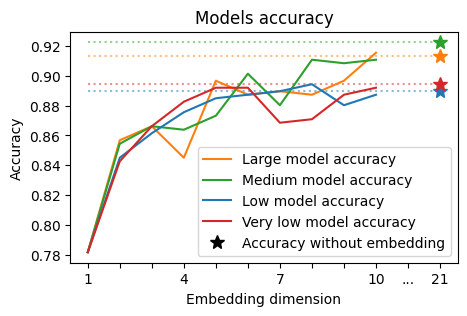

In [18]:
# summarize history for accuracy

plt.figure(figsize=(5,3))
plt.plot(model_base, color=('tab:orange', 0.5), ls=':')
plt.plot(model_med_base, color=('tab:green', 0.5), ls=':')
plt.plot(model_low_base, color=('tab:blue', 0.5), ls=':')
plt.plot(model_verylow_base, color=('tab:red',0.5), ls=':')

plt.plot(len(acc_test_large) + 1, model_large_acc, marker='*', color='tab:orange', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_med) + 1, model_med_acc, marker='*', color='tab:green', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_low) + 1, model_low_acc, marker='*', color='tab:blue', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_verylow) + 1, model_verylow_acc, marker='*', color='tab:red', markersize=10, linestyle='None', label='_nolegend_')

plt.plot(acc_test_large, label='Large model accuracy', color='tab:orange', ls='-')
plt.plot(acc_test_med, label='Medium model accuracy', color='tab:green', ls='-')
plt.plot(acc_test_low, label='Low model accuracy', color='tab:blue', ls='-')
plt.plot(acc_test_verylow, label='Very low model accuracy', color='tab:red', ls='-')

black_star_proxy = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                 markersize=10, label='Accuracy without embedding')

plt.title('Models accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Embedding dimension')
plt.xticks(ticks, index)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(black_star_proxy)

plt.legend(handles=handles)
plt.savefig('figures/fetal_health_accuracy_full.pgf', bbox_inches='tight', dpi=4000)
plt.savefig('figures/fetal_health_accuracy_full.png', bbox_inches='tight', dpi=2000)

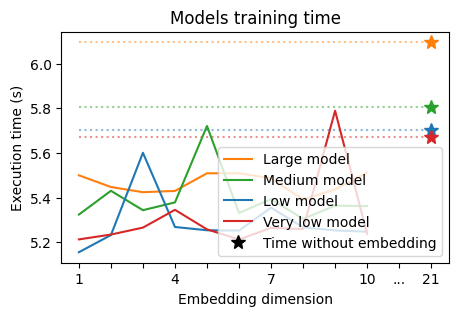

In [19]:
#Plot training time


plt.figure(figsize=(5,3))
plt.plot(time_base_large, color=('tab:orange', 0.5), ls=':')
plt.plot(time_base_med, color=('tab:green', 0.5), ls=':')
plt.plot(time_base_low, color=('tab:blue', 0.5), ls=':')
plt.plot(time_base_verylow, color=('tab:red',0.5), ls=':')

plt.plot(len(acc_test_large) + 1, base_time_train[0], marker='*', color='tab:orange', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_med) + 1, base_time_train[1], marker='*', color='tab:green', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_low) + 1, base_time_train[2], marker='*', color='tab:blue', markersize=10, linestyle='None', label='_nolegend_')
plt.plot(len(acc_test_verylow) + 1, base_time_train[3], marker='*', color='tab:red', markersize=10, linestyle='None', label='_nolegend_')

plt.plot(time_large, label='Large model', color='tab:orange', ls='-')
plt.plot(time_med, label='Medium model', color='tab:green', ls='-')
plt.plot(time_low, label='Low model', color='tab:blue', ls='-')
plt.plot(time_verylow, label='Very low model', color='tab:red', ls='-')


black_star_proxy = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                                 markersize=10, label='Time without embedding')

plt.title('Models training time')
plt.ylabel('Execution time (s)')
plt.xlabel('Embedding dimension')
plt.xticks(ticks, index)

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(black_star_proxy)

plt.legend(handles=handles)
plt.savefig('figures/training_time_fetal_health_accuracy_full.pgf', bbox_inches='tight', dpi=4000)
plt.savefig('figures/training_time_fetal_health_accuracy_full.png', bbox_inches='tight', dpi=2000)
